<a href="https://colab.research.google.com/github/Followb1ind1y/D2L_Pytorch_Study_Notes/blob/main/12_D2L_Optimization_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dive into Deep Learning 中文学习笔记** 
# **12. 优化算法 （Optimization Algorithms）**


##**12.1. 优化和深度学习（Optimization and Deep Learning）**

在一个深度学习问题中，我们通常会预先定义一个损失函数。有了损失函数以后，我们就可以使用优化算法试图将其最小化。在优化中，这样的损失函数通常被称作优化问题的 **目标函数（*objective function*）**。依据惯例，优化算法通常只考虑最小化目标函数。其实，任何最大化问题都可以很容易地转化为最小化问题，只需令目标函数的相反数为新的目标函数即可。

In [ ]:
%matplotlib inline
import numpy as np
import torch
from mpl_toolkits import mplot3d
from d2l import torch as d2l

### **12.1.1. 优化目标（Goal of Optimization）**

虽然优化为深度学习提供了最小化损失函数的方法，但本质上，优化与深度学习的目标是有区别的。 在模型选择、欠拟合和过拟合中，我们区分了训练误差和泛化误差。 由于优化算法的目标函数通常是一个基于训练数据集的损失函数，**优化的目标在于降低训练误差**。 而**深度学习的目标在于降低泛化误差**。为了降低泛化误差，除了使用优化算法降低训练误差以外，还需要注意应对过拟合。

为了说明上述不同的目标，我们来考虑一下 **经验风险（*empirical risk*）** 和 **风险（*risk*)**。经验风险是训练数据集上的**平均损失**，而风险是整个数据群上的**预期损失**。下面我们定义两个函数：风险函数 $f$ 和经验风险函数 $g$。假设我们只有有限数量的训练数据。因此，这里 $g$ 比 $f$ 更不平滑。

In [ ]:
def f(x):
    return x * torch.cos(np.pi * x)

def g(x):
    return f(x) + 0.2 * torch.cos(5 * np.pi * x)

下图说明，训练数据集上的经验风险的最小值可能与风险的最小值（泛化误差）在不同的位置:

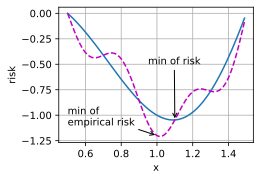

In [ ]:
def annotate(text, xy, xytext):
    d2l.plt.gca().annotate(text, xy=xy, xytext=xytext,
                           arrowprops=dict(arrowstyle='->'))

x = torch.arange(0.5, 1.5, 0.01)
d2l.set_figsize((4.5, 2.5))
d2l.plot(x, [f(x), g(x)], 'x', 'risk')
annotate('min of\nempirical risk', (1.0, -1.2), (0.5, -1.1))
annotate('min of risk', (1.1, -1.05), (0.95, -0.5))

我们在这里只关注优化算法在最小化目标函数上的表现，而不关注模型的泛化误差。

###**12.1.2. 优化在深度学习中的挑战（Optimization Challenges in Deep Learning）**

我们在线性回归中对优化问题的**解析解（*analytical solutions*）**和**数值解（*numerical solutions*）**做了区分。深度学习中绝大多数目标函数都很复杂。因此，很多优化问题**并不存在解析解**，而需要使用基于数值方法的**优化算法找到近似解**，即数值解。我们讨论的优化算法都是这类基于数值方法的算法。为了求得最小化目标函数的数值解，我们将通过优化算法有限次迭代模型参数来尽可能降低损失函数的值。


**12.1.2.1. 局部最小值（Local Minima）**

对于目标函数 $f(x)$，如果 $f(x)$ 在 $x$ 上的值比在 $x$ 邻近的其他点的值更小，那么 $f(x)$ 可能是一个 **局部最小值（*local minimum*）**。如果 $f(x)$ 在 $x$ 上的值是目标函数在整个定义域上的最小值，那么 $f(x)$ 是 **全局最小值（*global minimum*）**。

举个例子，给定函数

$$
f(x) = x \cdot \text{cos}(\pi x), \qquad -1.0 \leq x \leq 2.0,
$$

我们可以大致找出该函数的局部最小值和全局最小值的位置。需要注意的是，图中箭头所指示的只是大致位置。

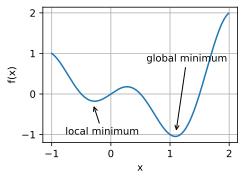

In [ ]:
x = torch.arange(-1.0, 2.0, 0.01)
d2l.plot(x, [f(x), ], 'x', 'f(x)')
annotate('local minimum', (-0.3, -0.25), (-0.77, -1.0))
annotate('global minimum', (1.1, -0.95), (0.6, 0.8))

深度学习模型的目标函数可能有若干局部最优值。当一个优化问题的数值解在局部最优解附近时，由于目标函数有关解的梯度接近或变成零，最终迭代求得的数值解可能只令目标函数局部最小化而非全局最小化。

**12.1.2.2. 鞍点（Saddle Points）**

刚刚我们提到，梯度接近或变成零可能是由于当前解在局部最优解附近造成的。事实上，另一种可能性是当前解在 **鞍点（*saddle point*）** 附近。鞍点是一个函数的所有梯度都消失的任何位置，但它既不是全局也不是局部最小值。

举个例子，给定函数

$$f(x) = x^3,$$

我们可以找出该函数的鞍点位置。

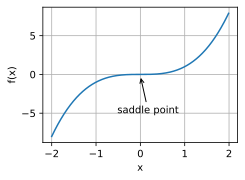

In [ ]:
x = torch.arange(-2.0, 2.0, 0.01)
d2l.plot(x, [x**3], 'x', 'f(x)')
annotate('saddle point', (0, -0.2), (-0.52, -5.0))

更高维度上的鞍点甚至更加隐蔽，正如下面的例子所示:

$$f(x, y) = x^2 - y^2.$$

我们可以找出该函数的鞍点位置。也许你已经发现了，该函数看起来像一个马鞍，而鞍点恰好是马鞍上可坐区域的中心。

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


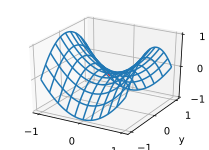

In [ ]:
x, y = torch.meshgrid(
    torch.linspace(-1.0, 1.0, 101), torch.linspace(-1.0, 1.0, 101))
z = x**2 - y**2

ax = d2l.plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 10, 'cstride': 10})
ax.plot([0], [0], [0], 'rx')
ticks = [-1, 0, 1]
d2l.plt.xticks(ticks)
d2l.plt.yticks(ticks)
ax.set_zticks(ticks)
d2l.plt.xlabel('x')
d2l.plt.ylabel('y');

我们假设一个函数的输入是一个 $k$-维向量，其输出是一个标量，因此其 Hessian 矩阵将有 $k$ 个特征值。该函数的解可能是局部最小值、局部最大值，或者是函数梯度为零的位置上的一个鞍点：

* 当函数的 Hessian 矩阵在梯度为零的位置上的特征值全为正时，该函数得到局部最小值。
* 当函数的 Hessian 矩阵在梯度为零的位置上的特征值全为负时，该函数得到局部最大值。
* 当函数的 Hessian 矩阵在梯度为零的位置上的特征值有正有负时，该函数得到鞍点。

对于高维问题，至少有一些特征值是负值的可能性相当高。这使得**鞍点比局部最小点更有可能**。简而言之，**凸函数（*convex functions*）** 是那些 Hessian 的**特征值永远不会是负值的函数**。但可惜的的是，大多数深度学习问题并不属于这个类别。尽管如此，它仍然是研究优化算法的一个实用工具。

**12.1.2.3. 梯度消失（Vanishing Gradients）**

可能遇到的最隐蔽的问题是梯度消失。回顾我们在之前中常用的激活函数和它们的导数。例如，假设我们想使函数 $f(x) = \tanh(x)$ 最小化，而我们碰巧在 $x = 4$ 处开始。我们可以看到，$f$ 的梯度接近于零。更确切地说，因为 $f'(x) = 1 - \tanh^2(x)$，所以 $f'(4) = 0.0013$，在我们取得进展之前，优化会被卡住很长时间。在引入 ReLU 激活函数之前，这是训练深度学习模型相当棘手的原因之一。

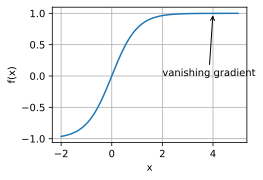

In [ ]:
x = torch.arange(-2.0, 5.0, 0.01)
d2l.plot(x, [torch.tanh(x)], 'x', 'f(x)')
annotate('vanishing gradient', (4, 1), (2, 0.0))

我们**并不是真的需要找到最佳解**。局部最优，甚至是其中的近似解，仍然非常有用。

## **12.3. 梯度下降（Gradient Descent）**

### **12.3.1. 一维梯度下降（One-Dimensional Gradient Descent）**

我们先以简单的一维梯度下降为例，解释梯度下降算法可能降低目标函数值的原因。假设连续可导的函数$f: \mathbb{R} \rightarrow \mathbb{R}$的输入和输出都是标量。给定绝对值足够小的数$\epsilon$，根据泰勒展开公式，我们得到以下的近似：

$$f(x + \epsilon) \approx f(x) + \epsilon f'(x) .$$

这里$f'(x)$是函数$f$在$x$处的梯度。一维函数的梯度是一个标量，也称导数。

接下来，找到一个常数$\eta > 0$，使得$\left|\eta f'(x)\right|$足够小，那么可以将$\epsilon$替换为$-\eta f'(x)$并得到

$$f(x - \eta f'(x)) \approx f(x) -  \eta f'(x)^2.$$

如果导数$f'(x) \neq 0$，那么$\eta f'(x)^2>0$，所以

$$f(x - \eta f'(x)) \lesssim f(x).$$

这意味着，如果通过

$$x \leftarrow x - \eta f'(x)$$

来迭代$x$，函数$f(x)$的值可能会降低。因此在梯度下降中，我们先选取一个初始值$x$和常数$\eta > 0$，然后不断通过上式来迭代$x$，直到达到停止条件，例如$f'(x)^2$的值已足够小或迭代次数已达到某个值。

下面我们以目标函数$f(x)=x^2$为例来看一看梯度下降是如何工作的。虽然我们知道最小化$f(x)$的解为$x=0$，这里依然使用这个简单函数来观察$x$是如何被迭代的。

In [ ]:
%matplotlib inline
import numpy as np
import torch
from d2l import torch as d2l
from torch import nn

def f(x):  # Objective function
    return x ** 2

def f_grad(x):  # Gradient (derivative) of the objective function
    return 2 * x

接下来使用$x=10$作为初始值，并设$\eta=0.2$。使用梯度下降对$x$迭代10次，可见最终$x$的值较接近最优解。

In [ ]:
def gd(eta, f_grad):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x)
        results.append(float(x))
    print(f'epoch 10, x: {x:f}')
    return results

results = gd(0.2, f_grad)

epoch 10, x: 0.060466


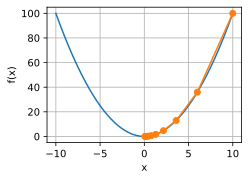

In [ ]:
def show_trace(results, f):
    n = max(abs(min(results)), abs(max(results)))
    f_line = torch.arange(-n, n, 0.01)
    d2l.set_figsize()
    d2l.plot([f_line, results], [[f(x) for x in f_line], [
        f(x) for x in results]], 'x', 'f(x)', fmts=['-', '-o'])

show_trace(results, f)

**12.3.1.1. 学习率（Learning Rate）**

上述梯度下降算法中的正数$\eta$通常叫作 **学习率（*Learning Rate*）**。这是一个超参数，需要人工设定。如果使用过小的学习率，会导致$x$更新缓慢从而需要更多的迭代才能得到较好的解。

下面展示使用学习率$\eta=0.05$时自变量$x$的迭代轨迹。可见，同样迭代10次后，当学习率过小时，最终$x$的值依然与最优解存在较大偏差。

epoch 10, x: 3.486784


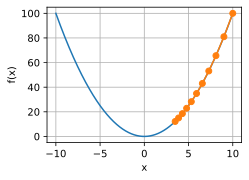

In [ ]:
show_trace(gd(0.05, f_grad), f)

如果使用过大的学习率，$\left|\eta f'(x)\right|$可能会过大从而使前面提到的一阶泰勒展开公式不再成立：这时我们无法保证迭代$x$会降低$f(x)$的值。

举个例子，当设学习率$\eta=1.1$时，可以看到$x$不断越过（overshoot）最优解$x=0$并逐渐发散。

epoch 10, x: 61.917364


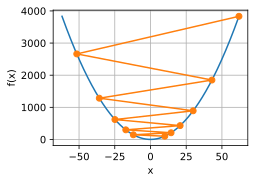

In [ ]:
show_trace(gd(1.1, f_grad), f)

**12.3.1.2. 局部最小值（Local Minima）**

为了说明非凸函数的情况，请考虑对于某个常数 $c$，$f(x) = x \cdot \cos(cx)$ 的情况。这个函数有无限多的局部极值。根据我们对学习率的选择，以及问题的条件有多好，我们最终可能得到许多解决方案中的一个。下面的例子说明了一个（不切实际的）高学习率是如何导致一个糟糕的局部最小值的。

epoch 10, x: -1.528166


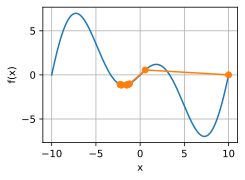

In [ ]:
c = torch.tensor(0.15 * np.pi)

def f(x):  # Objective function
    return x * torch.cos(c * x)

def f_grad(x):  # Gradient of the objective function
    return torch.cos(c * x) - c * x * torch.sin(c * x)

show_trace(gd(2, f_grad), f)

###**12.3.2. 多维梯度下降（Multivariate Gradient Descent）**

在了解了一维梯度下降之后，我们再考虑一种更广义的情况：目标函数的输入为向量，输出为标量。假设目标函数$f: \mathbb{R}^d \rightarrow \mathbb{R}$的输入是一个$d$维向量$\boldsymbol{x} = [x_1, x_2, \ldots, x_d]^\top$。目标函数$f(\boldsymbol{x})$有关$\boldsymbol{x}$的梯度是一个由$d$个偏导数组成的向量：

$$\nabla_{\boldsymbol{x}} f(\boldsymbol{x}) = \bigg[\frac{\partial f(\boldsymbol{x})}{\partial x_1}, \frac{\partial f(\boldsymbol{x})}{\partial x_2}, \ldots, \frac{\partial f(\boldsymbol{x})}{\partial x_d}\bigg]^\top.$$


为表示简洁，我们用$\nabla f(\boldsymbol{x})$代替$\nabla_{\boldsymbol{x}} f(\boldsymbol{x})$。梯度中每个偏导数元素$\partial f(\boldsymbol{x})/\partial x_i$代表着$f$在$\boldsymbol{x}$有关输入$x_i$的变化率。为了测量$f$沿着单位向量$\boldsymbol{u}$（即$\|\boldsymbol{u}\|=1$）方向上的变化率，在多元微积分中，我们定义$f$在$\boldsymbol{x}$上沿着$\boldsymbol{u}$方向的方向导数为

$$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x}) = \lim_{h \rightarrow 0}  \frac{f(\boldsymbol{x} + h \boldsymbol{u}) - f(\boldsymbol{x})}{h}.$$

依据方向导数性质，以上方向导数可以改写为

$$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x}) = \nabla f(\boldsymbol{x}) \cdot \boldsymbol{u}.$$

方向导数$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x})$给出了$f$在$\boldsymbol{x}$上沿着所有可能方向的变化率。为了最小化$f$，我们希望找到$f$能被降低最快的方向。因此，我们可以通过单位向量$\boldsymbol{u}$来最小化方向导数$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x})$。

由于$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x}) = \|\nabla f(\boldsymbol{x})\| \cdot \|\boldsymbol{u}\|  \cdot \text{cos} (\theta) = \|\nabla f(\boldsymbol{x})\|  \cdot \text{cos} (\theta)$，
其中$\theta$为梯度$\nabla f(\boldsymbol{x})$和单位向量$\boldsymbol{u}$之间的夹角，当$\theta = \pi$时，$\text{cos}(\theta)$取得最小值$-1$。因此，当$\boldsymbol{u}$在梯度方向$\nabla f(\boldsymbol{x})$的相反方向时，方向导数$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x})$被最小化。因此，我们可能通过梯度下降算法来不断降低目标函数$f$的值：

$$\boldsymbol{x} \leftarrow \boldsymbol{x} - \eta \nabla f(\boldsymbol{x}).$$

同样，其中$\eta$（取正数）称作学习率。

下面我们构造一个输入为二维向量$\boldsymbol{x} = [x_1, x_2]^\top$和输出为标量的目标函数$f(\boldsymbol{x})=x_1^2+2x_2^2$。那么，梯度$\nabla f(\boldsymbol{x}) = [2x_1, 4x_2]^\top$。我们将观察梯度下降从初始位置$[-5,-2]$开始对自变量$\boldsymbol{x}$的迭代轨迹。我们先定义两个辅助函数，第一个函数使用给定的自变量更新函数，从初始位置$[-5,-2]$开始迭代自变量$\boldsymbol{x}$共20次，第二个函数对自变量$\boldsymbol{x}$的迭代轨迹进行可视化。

In [ ]:
def train_2d(trainer, steps=20, f_grad=None):
    """Optimize a 2D objective function with a customized trainer."""
    # `s1` and `s2` are internal state variables that will be used in Momentum, adagrad, RMSProp
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results

def show_trace_2d(f, results):
    """Show the trace of 2D variables during optimization."""
    d2l.set_figsize()
    d2l.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = torch.meshgrid(torch.arange(-5.5, 1.0, 0.1),
                          torch.arange(-3.0, 1.0, 0.1))
    d2l.plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

epoch 20, x1: -0.057646, x2: -0.000073


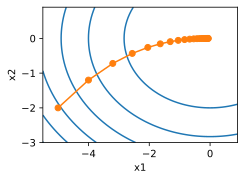

In [ ]:
def f_2d(x1, x2):  # Objective function
    return x1 ** 2 + 2 * x2 ** 2

def f_2d_grad(x1, x2):  # Gradient of the objective function
    return (2 * x1, 4 * x2)

def gd_2d(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    return (x1 - eta * g1, x2 - eta * g2, 0, 0)

eta = 0.1
show_trace_2d(f_2d, train_2d(gd_2d, f_grad=f_2d_grad))

##**12.4. 随机梯度下降（Stochastic Gradient Descent）**

In [ ]:
%matplotlib inline
import math
import torch
from d2l import torch as d2l

### **12.4.1. 随机梯度下降更新（Stochastic Gradient Updates）**

在深度学习里，目标函数通常是训练数据集中有关各个样本的损失函数的平均。设$f_i(\boldsymbol{x})$是有关索引为$i$的训练数据样本的损失函数，$n$是训练数据样本数，$\boldsymbol{x}$是模型的参数向量，那么目标函数定义为

$$f(\boldsymbol{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\boldsymbol{x}).$$

目标函数在 $\boldsymbol{x}$ 处的梯度计算为

$$\nabla f(\boldsymbol{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\boldsymbol{x}).$$

如果使用梯度下降，每次自变量迭代的计算开销为$\mathcal{O}(n)$，它随着$n$线性增长。因此，当训练数据样本数很大时，梯度下降每次迭代的计算开销很高。

**随机梯度下降（*stochastic gradient descent，SGD*）** 减少了每次迭代的计算开销。在随机梯度下降的每次迭代中，我们随机均匀采样的一个样本索引$i\in\{1,\ldots,n\}$，并计算梯度$\nabla f_i(\boldsymbol{x})$来迭代$\boldsymbol{x}$：

$$\boldsymbol{x} \leftarrow \boldsymbol{x} - \eta \nabla f_i(\boldsymbol{x}).$$

这里$\eta$同样是学习率。可以看到每次迭代的计算开销从梯度下降的$\mathcal{O}(n)$降到了常数$\mathcal{O}(1)$。值得强调的是，随机梯度$\nabla f_i(\boldsymbol{x})$是对梯度$\nabla f(\boldsymbol{x})$的无偏估计：

$$E_i \nabla f_i(\boldsymbol{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\boldsymbol{x}) = \nabla f(\boldsymbol{x}).$$

这意味着，平均来说，随机梯度是对梯度的一个良好的估计。

下面我们通过在梯度中添加均值为0的随机噪声来模拟随机梯度下降，以此来比较它与梯度下降的区别。

epoch 50, x1: -0.231960, x2: 0.028714


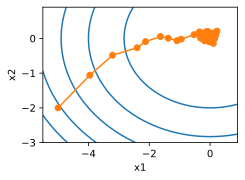

In [ ]:
def f(x1, x2):  # Objective function
    return x1 ** 2 + 2 * x2 ** 2

def f_grad(x1, x2):  # Gradient of the objective function
    return 2 * x1, 4 * x2

def sgd(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    # Simulate noisy gradient
    g1 += torch.normal(0.0, 1, (1,)).item()
    g2 += torch.normal(0.0, 1, (1,)).item()
    eta_t = eta * lr()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)

def constant_lr():
    return 1

eta = 0.1
lr = constant_lr  # Constant learning rate
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

###**12.4.2. 动态学习率（Dynamic Learning Rate）**

用随时间变化的学习率 $𝜂(𝑡)$ 来代替 $𝜂$，增加了控制优化算法收敛的复杂性。特别是，我们需要弄清楚 $𝜂$ 应该以何种速度衰减。如果它太快了，我们就会过早地停止优化。如果我们降低得太慢，我们就会在优化上浪费太多的时间。以下是在调整 $𝜂$ 时随时间推移而采用的一些基本策略:

$$
\begin{aligned}
    \eta(t) & = \eta_i \text{ if } t_i \leq t \leq t_{i+1}  && \text{piecewise constant} \\
    \eta(t) & = \eta_0 \cdot e^{-\lambda t} && \text{exponential decay} \\
    \eta(t) & = \eta_0 \cdot (\beta t + 1)^{-\alpha} && \text{polynomial decay}
\end{aligned}
$$

在第一种片状常数情况下，我们降低学习率，例如，每当优化进展停滞不前时。这是训练深度网络的一个常见策略。另外，我们可以通过指数衰减的方式更积极地降低学习率。不幸的是，这往往会导致在算法收敛之前过早地停止。一个流行的选择是多项式衰减，$𝛼=0.5$。在凸优化的情况下，有许多证明表明这个速率是良好的。

epoch 1000, x1: -0.853412, x2: -0.089197


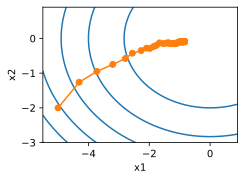

In [ ]:
def exponential_lr():
    # Global variable that is defined outside this function and updated inside
    global t
    t += 1
    return math.exp(-0.1 * t)

t = 1
lr = exponential_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=1000, f_grad=f_grad))

正如预期的那样，参数的方差明显减少。然而，这是以无法收敛到最优解 $x=(0,0)$为代价的。即使经过1000个迭代步骤，我们仍然离最优解很远。事实上，该算法根本无法收敛。另一方面，如果我们使用多项式衰减，即学习率随着步数的反平方根而衰减，那么仅在50步之后收敛就会好转。

epoch 50, x1: 0.106669, x2: 0.026719


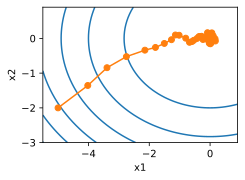

In [ ]:
def polynomial_lr():
    # Global variable that is defined outside this function and updated inside
    global t
    t += 1
    return (1 + 0.1 * t) ** (-0.5)

t = 1
lr = polynomial_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

## **12.5. 小批量随机梯度下降 (Minibatch Stochastic Gradient Descent)**

### **12.5.2. 小批量（Minibatches）**


在每一次迭代中，梯度下降使用整个训练数据集来计算梯度，因此它有时也被称为 **批量梯度下降（*batch gradient descent*）**。而随机梯度下降在每次迭代中只随机采样一个样本来计算梯度。正如我们在前几章中所看到的，我们还可以在每轮迭代中随机均匀采样多个样本来组成一个小批量，然后使用这个小批量来计算梯度。下面就来描述小批量随机梯度下降。


设目标函数$f(\boldsymbol{x}): \mathbb{R}^d \rightarrow \mathbb{R}$。在迭代开始前的时间步设为0。该时间步的自变量记为$\boldsymbol{x}_0\in \mathbb{R}^d$，通常由随机初始化得到。在接下来的每一个时间步$t>0$中，小批量随机梯度下降随机均匀采样一个由训练数据样本索引组成的小批量$\mathcal{B}_t$。我们可以通过 **重复采样（*sampling with replacement*）** 或者 **不重复采样（*sampling without replacement*）** 得到一个小批量中的各个样本。前者允许同一个小批量中出现重复的样本，后者则不允许如此，且更常见。对于这两者间的任一种方式，都可以使用

$$
\boldsymbol{g}_t \leftarrow \nabla f_{\mathcal{B}_t}(\boldsymbol{x}_{t-1}) = \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t}\nabla f_i(\boldsymbol{x}_{t-1})
$$

来计算时间步$t$的小批量$\mathcal{B}_t$上目标函数位于$\boldsymbol{x}_{t-1}$处的梯度$\boldsymbol{g}_t$。这里$|\mathcal{B}|$代表批量大小，即小批量中样本的个数，是一个超参数。同随机梯度一样，重复采样所得的小批量随机梯度$\boldsymbol{g}_t$也是对梯度$\nabla f(\boldsymbol{x}_{t-1})$的无偏估计。给定学习率$\eta_t$（取正数），小批量随机梯度下降对自变量的迭代如下：

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \eta_t \boldsymbol{g}_t.$$

基于随机采样得到的梯度的方差在迭代过程中无法减小，因此在实际中，（小批量）随机梯度下降的学习率可以在迭代过程中自我衰减，例如$\eta_t=\eta t^\alpha$（通常$\alpha=-1$或者$-0.5$）、$\eta_t = \eta \alpha^t$（如$\alpha=0.95$）或者每迭代若干次后将学习率衰减一次。如此一来，学习率和（小批量）随机梯度乘积的方差会减小。而梯度下降在迭代过程中一直使用目标函数的真实梯度，无须自我衰减学习率。


小批量随机梯度下降中每次迭代的计算开销为$\mathcal{O}(|\mathcal{B}|)$。当批量大小为1时，该算法即为随机梯度下降；当批量大小等于训练数据样本数时，该算法即为梯度下降。当批量较小时，每次迭代中使用的样本少，这会导致**并行处理和内存使用效率变低**。这使得在计算同样数目样本的情况下比使用更大批量时所花时间更多。当批量较大时，每个小批量梯度里可能含有更多的冗余信息。**为了得到较好的解，批量较大时比批量较小时需要计算的样本数目可能更多**，例如增大迭代周期数。

###**12.5.3. 读取数据（Reading the Dataset）**

本章里我们将使用一个来自 NASA 的测试不同飞机机翼噪音的数据集来比较各个优化算法。我们使用该数据集的前 1,500 个样本和 5 个特征，并使用标准化对数据进行预处理。



In [ ]:
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')

def get_data_ch11(batch_size=10, n=1500):
    data = np.genfromtxt(d2l.download('airfoil'),
                         dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]),
                               batch_size, is_train=True)
    return data_iter, data.shape[1]-1

### **12.5.4. 从零实现（Implementation from Scratch）**

在线性回归的从零开始实现中已经实现过小批量随机梯度下降算法。我们在这里将它的输入参数变得更加通用，主要是为了方便本章后面介绍的其他优化算法也可以使用同样的输入。具体来说，我们添加了一个状态输入 `states` 并将超参数放在字典 `hyperparams` 里。此外，我们将在训练函数里对各个小批量样本的损失求平均，因此优化算法里的梯度不需要除以批量大小。

In [ ]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_()

下面实现一个通用的训练函数，以方便本章后面介绍的其他优化算法使用。它初始化一个线性回归模型，然后可以使用小批量随机梯度下降以及后续小节介绍的其他算法来训练模型。

In [ ]:
def train_ch11(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    # Initialization
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    # Train
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.sum()/num_epochs:.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

当批量大小为样本总数 1,500 时，优化使用的是梯度下降。梯度下降的 1 个迭代周期对模型参数只迭代 1 次。可以看到 6 次迭代后目标函数值（训练损失）的下降趋向了平稳。

loss: 0.246, 0.024 sec/epoch


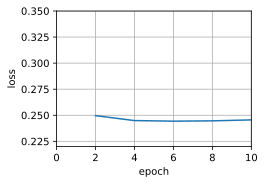

In [ ]:
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size)
    return train_ch11(
        sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)

gd_res = train_sgd(1, 1500, 10)

当批量大小为 1 时，优化使用的是随机梯度下降。为了简化实现，有关（小批量）随机梯度下降的实验中，我们未对学习率进行自我衰减，而是直接采用较小的常数学习率。随机梯度下降中，每处理一个样本会更新一次自变量（模型参数），一个迭代周期里会对自变量进行 1,500 次更新。可以看到，目标函数值的下降在 1 个迭代周期后就变得较为平缓。

虽然随机梯度下降和梯度下降在一个迭代周期里都处理了 1,500 个样本，但实验中随机梯度下降的一个迭代周期耗时更多。这是因为随机梯度下降在一个迭代周期里做了更多次的自变量迭代，而且**单样本的梯度计算难以有效利用矢量计算**。

loss: 0.246, 0.640 sec/epoch


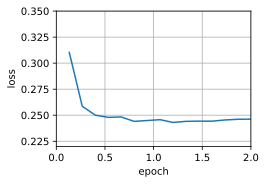

In [ ]:
sgd_res = train_sgd(0.005, 1)

当批次大小等于 100 时，我们使用迷你批次随机梯度下降法进行优化。每个历时所需的时间比随机梯度下降所需的时间和批量梯度下降的时间都要短

loss: 0.245, 0.055 sec/epoch


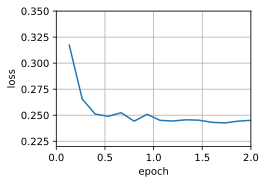

In [ ]:
mini1_res = train_sgd(.4, 100)

当批量大小为 10 时，优化使用的是小批量随机梯度下降。它在每个迭代周期的耗时介于梯度下降和随机梯度下降的耗时之间。

loss: 0.246, 0.139 sec/epoch


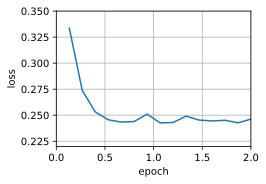

In [ ]:
mini2_res = train_sgd(.05, 10)

现在我们可以比较前面四个实验的时间与损失。可以看出，虽然从处理的例子数量来看，随机梯度下降法比 GD 收敛得更快，但由于逐个例子计算梯度的效率不高，所以它在达到相同损失时使用的时间比 GD 多。Minibatch 随机梯度下降法能够在收敛速度和计算效率之间进行权衡。10 的迷你批大小比随机梯度下降法更有效；100 的迷你批大小甚至在运行时间上比 GD 更快。

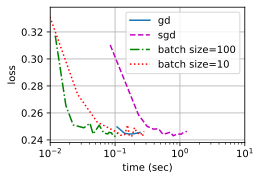

In [ ]:
d2l.set_figsize([6, 3])
d2l.plot(*list(map(list, zip(gd_res, sgd_res, mini1_res, mini2_res))),
         'time (sec)', 'loss', xlim=[1e-2, 10],
         legend=['gd', 'sgd', 'batch size=100', 'batch size=10'])
d2l.plt.gca().set_xscale('log')

### **12.5.5. 简洁实现（Concise Implementation）**


In [ ]:
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # Initialization
    net = nn.Sequential(nn.Linear(5, 1))
    def init_weights(module):
        if type(module) == nn.Linear:
            torch.nn.init.normal_(module.weight, std=0.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = nn.MSELoss(reduction='none')
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                # `MSELoss` computes squared error without the 1/2 factor
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss) / 2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.sum()/num_epochs:.3f} sec/epoch')

loss: 0.242, 0.153 sec/epoch


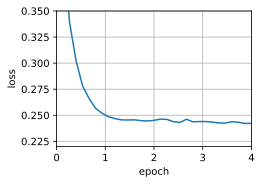

In [ ]:
data_iter, _ = get_data_ch11(10)
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

## **12.6. 动量法 (Momentum)**

在梯度下降和随机梯度下降中我们提到，目标函数有关自变量的梯度代表了目标函数在自变量当前位置下降最快的方向。因此，梯度下降也叫作 **最陡下降（*steepest descent*）**。在每次迭代中，梯度下降根据自变量当前位置，沿着当前位置的梯度更新自变量。然而，如果自变量的迭代方向仅仅取决于自变量当前位置，这可能会带来一些问题。

### **12.6.1. 基本知识（Basics）**

**12.6.1.1. 泄漏平均值（Leaky Averages）**

小批量 SGD 作为加速计算的一种手段。它还有一个很好的副作用，即平均梯度可以减少差异量。小批量随机梯度下降可以通过以下方式计算：

$$\mathbf{g}_{t, t-1} = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w}_{t-1}) = \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} \mathbf{h}_{i, t-1}$$

为了保持简单的符号，在这里我们使用 $\mathbf{h}_{i, t-1} = \partial_{\mathbf{w}} f(\mathbf{x}_i, \mathbf{w}_{t-1})$ 作为随机梯度下降法样本 $i$ 在时间 $t-1$ 上更新的权重。如果我们能从减少方差的效果中获益，甚至超越迷你批次的平均梯度，那就更好了。完成这一任务的一个选择是用 泄漏平均值（Leaky Averages） 来代替梯度计算。

$$\mathbf{v}_t = \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}$$

其中 $\beta \in (0, 1)$。 这有效地将瞬时梯度替换为多个过去梯度的平均值。 
$v$ 被称为速度（*velocity*）， 它累加了过去的梯度。 为了更详细地解释，让我们递归地将 $\mathbf{v}_t$ 扩展到

$$\begin{aligned}
\mathbf{v}_t = \beta^2 \mathbf{v}_{t-2} + \beta \mathbf{g}_{t-1, t-2} + \mathbf{g}_{t, t-1}
= \ldots, = \sum_{\tau = 0}^{t-1} \beta^{\tau} \mathbf{g}_{t-\tau, t-\tau-1}.
\end{aligned}$$

其中，较大的 $\beta$ 相当于长期平均值，而较小的 $\beta$ 相对于梯度法只是略有修正。新的梯度替换不再指向特定实例下降最陡的方向，而是指向**过去梯度的加权平均值的方向**。这使我们能够实现对单批量计算平均值的大部分好处，而不产生实际计算其梯度的代价。

上述推理形成了现在所称的 **加速梯度方法（*accelerated gradient methods*）** 的基础，如带动量的梯度。它们还有一个好处，就是在**优化问题条件不佳的情况下**（即有些方向的进展比其他方向慢得多）更加有效。此外，它们允许我们对后续梯度进行平均，以获得更稳定的下降方向。事实上，即使对于无噪声的凸问题，加速方面也是动量发挥作用的关键原因之一，也是为什么动量如此有效的原因。

**12.6.1.2. 梯度下降的问题（An Ill-conditioned Problem）**

让我们考虑一个输入和输出分别为二维向量 $\boldsymbol{x} = [x_1, x_2]^\top$ 和标量的目标函数 $f(\boldsymbol{x})=0.1x_1^2+2x_2^2$。这里将 $x_1^2$ 系数从 $1$ 减小到了 $0.1$。下面实现基于这个目标函数的梯度下降，并演示使用学习率为 $0.4$ 时自变量的迭代轨迹。

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch 20, x1: -0.943467, x2: -0.000073


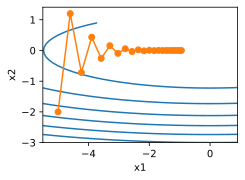

In [2]:
%matplotlib inline
import torch
from d2l import torch as d2l

eta = 0.4
def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2
def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

可以看到，同一位置上，目标函数在竖直方向（$x_2$轴方向）比在水平方向（$x_1$轴方向）的斜率的绝对值更大。因此，给定学习率，梯度下降迭代自变量时会**使自变量在竖直方向比在水平方向移动幅度更大**。那么，我们需要一个较小的学习率从而**避免自变量在竖直方向上越过目标函数最优解**。然而，这会造成自变量在水平方向上朝**最优解移动变慢**。

下面我们试着将学习率调得稍大一点，此时自变量在竖直方向不断越过最优解并逐渐发散。

epoch 20, x1: -0.387814, x2: -1673.365109


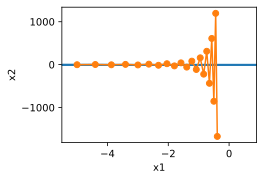

In [3]:
eta = 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

**12.6.1.3. 动量法（The Momentum Method）**

**动量法（*The Momentum Method*）** 的提出是为了解决梯度下降的上述问题。由于小批量随机梯度下降比梯度下降更为广义，我们后续讨论将沿用小批量随机梯度下降中时间步 $t$ 的小批量随机梯度 $\boldsymbol{g}_t$ 的定义。设时间步 $t$ 的自变量为 $\boldsymbol{x}_t$，学习率为 $\eta_t$。在时间步 $0$，动量法创建速度变量 $\boldsymbol{v}_0$，并将其元素初始化成0。在时间步 $t>0$，动量法对每次迭代的步骤做如下修改：

$$
\begin{split}\begin{aligned}
\mathbf{v}_t &\leftarrow \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}, \\
\mathbf{x}_t &\leftarrow \mathbf{x}_{t-1} - \eta_t \mathbf{v}_t.
\end{aligned}\end{split}
$$

其中，动量超参数 $\beta$ 满足$0 \leq \beta < 1$。当 $\beta=0$ 时，动量法等价于小批量随机梯度下降。

让我们先从实验中观察梯度下降在使用动量法后的迭代轨迹。

epoch 20, x1: 0.007188, x2: 0.002553


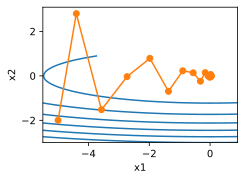

In [4]:
def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + 0.2 * x1
    v2 = beta * v2 + 4 * x2
    return x1 - eta * v1, x2 - eta * v2, v1, v2

eta, beta = 0.6, 0.5
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

可以看到使用较小的学习率 $\eta=0.4$ 和动量超参数 $\beta=0.5$ 时，动量法在竖直方向上的移动更加平滑，且在水平方向上更快逼近最优解。下面使用较大的学习率 $\eta=0.6$，此时自变量也不再发散。

epoch 20, x1: -0.126340, x2: -0.186632


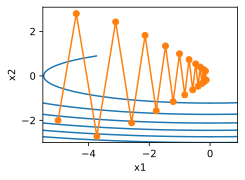

In [5]:
eta, beta = 0.6, 0.25
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

动量法将过去时间步的梯度做了加权平均，且权重按时间步指数衰减。它使得相邻时间步的自变量更新在方向上更加一致。

###**12.6.2. 实际实验（Practical Experiments）**

**12.6.2.1. 从零开始实现（Implementation from Scratch）**

与（小批量）随机梯度下降法相比，动量法需要保持一组辅助变量，即速度。它的形状与梯度（和优化问题的变量）相同。在下面的实现中，我们称这些变量为 `states`。

In [6]:
def init_momentum_states(feature_dim):
    v_w = torch.zeros((feature_dim, 1))
    v_b = torch.zeros(1)
    return (v_w, v_b)

def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        with torch.no_grad():
            v[:] = hyperparams['momentum'] * v + p.grad
            p[:] -= hyperparams['lr'] * v
        p.grad.data.zero_()

loss: 0.244, 0.189 sec/epoch


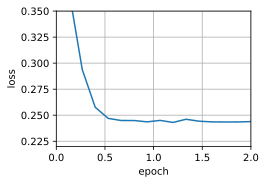

In [7]:
def train_momentum(lr, momentum, num_epochs=2):
    d2l.train_ch11(sgd_momentum, init_momentum_states(feature_dim),
                   {'lr': lr, 'momentum': momentum}, data_iter,
                   feature_dim, num_epochs)

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
train_momentum(0.02, 0.5)

**12.6.2.2. 简洁实现（Concise Implementation）**

loss: 0.247, 0.154 sec/epoch


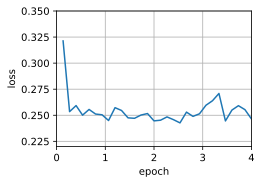

In [9]:
trainer = torch.optim.SGD
d2l.train_concise_ch11(trainer, {'lr': 0.005, 'momentum': 0.9}, data_iter)

## **12.7. AdaGrad算法（Adagrad）**

在之前介绍过的优化算法中，目标函数自变量的每一个元素在相同时间步都使用同一个学习率来自我迭代。举个例子，假设目标函数为 $f$，自变量为一个二维向量 $[x_1, x_2]^\top$，该向量中每一个元素在迭代时都使用相同的学习率。例如，在学习率为 $\eta$ 的梯度下降中，元素 $x_1$ 和 $x_2$ 都使用相同的学习率 $\eta$ 来自我迭代：

$$
x_1 \leftarrow x_1 - \eta \frac{\partial{f}}{\partial{x_1}}, \quad
x_2 \leftarrow x_2 - \eta \frac{\partial{f}}{\partial{x_2}}.
$$

在动量法里我们看到当 $x_1$ 和 $x_2$ 的梯度值有较大差别时，需要选择足够小的学习率使得自变量在梯度值较大的维度上不发散。但这样会导致自变量在梯度值较小的维度上迭代过慢。动量法依赖指数加权移动平均使得自变量的更新方向更加一致，从而降低发散的可能。本节我们介绍 **AdaGrad算法，它根据自变量在每个维度的梯度值的大小来调整各个维度上的学习率，从而避免统一的学习率难以适应所有维度的问题**。

###**12.7.3. 算法（The Algorithm）**

AdaGrad 算法会使用一个小批量随机梯度 $\boldsymbol{g}_t$ 按元素平方的累加变量 $\boldsymbol{s}_t$。在时间步 0，AdaGrad 将 $\boldsymbol{s}_0$ 中每个元素初始化为 0。在时间步 $t$，首先将小批量随机梯度 $\boldsymbol{g}_t$ 按元素平方后累加到变量$\boldsymbol{s}_t$：

$$\boldsymbol{s}_t \leftarrow \boldsymbol{s}_{t-1} + \boldsymbol{g}_t \odot \boldsymbol{g}_t,$$

其中 $\odot$ 是按元素相乘。接着，我们将目标函数自变量中每个元素的学习率通过按元素运算重新调整一下：

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \frac{\eta}{\sqrt{\boldsymbol{s}_t + \epsilon}} \odot \boldsymbol{g}_t,$$

其中 $\eta$ 是学习率，$\epsilon$ 是为了维持数值稳定性而添加的常数，如$10^{-6}$。这里开方、除法和乘法的运算都是按元素运算的。这些**按元素运算使得目标函数自变量中每个元素都分别拥有自己的学习率**。

需要强调的是，小批量随机梯度按元素平方的累加变量 $\boldsymbol{s}_t$ 出现在学习率的分母项中。因此，如果目标函数有关自变量中某个元素的偏导数一直都较大，那么该元素的学习率将下降较快；反之，如果目标函数有关自变量中某个元素的偏导数一直都较小，那么该元素的学习率将下降较慢。然而，由于 $\boldsymbol{s}_t$ 一直在累加按元素平方的梯度，自变量中每个元素的学习率在迭代过程中一直在降低（或不变）。所以，**当学习率在迭代早期降得较快且当前解依然不佳时，AdaGrad算法在迭代后期由于学习率过小，可能较难找到一个有用的解**。

下面我们仍然以目标函数 $f(\boldsymbol{x})=0.1x_1^2+2x_2^2$ 为例观察 AdaGrad 算法对自变量的迭代轨迹。我们实现 AdaGrad 算法并使用和上一节实验中相同的学习率0.4。可以看到，自变量的迭代轨迹较平滑。但由于 $\boldsymbol{s}_t$ 的累加效果使学习率不断衰减，自变量在迭代后期的移动幅度较小。

epoch 20, x1: -2.382563, x2: -0.158591


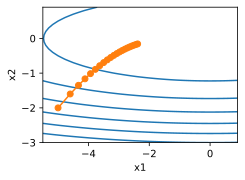

In [20]:
%matplotlib inline
import math
import torch
from d2l import torch as d2l

def adagrad_2d(x1, x2, s1, s2):
    eps = 1e-6
    g1, g2 = 0.2 * x1, 4 * x2
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

下面将学习率增大到2。可以看到自变量更为迅速地逼近了最优解。

epoch 20, x1: -0.002295, x2: -0.000000


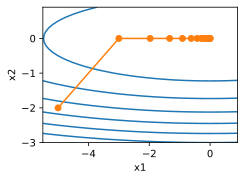

In [21]:
eta = 2
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

AdaGrad 算法在迭代过程中不断调整学习率，并让**目标函数自变量中每个元素都分别拥有自己的学习率**。 使用 AdaGrad 算法时，自变量中每个元素的学习率在迭代过程中一直在降低（或不变）。

###**12.7.4. 从零开始实现（Implementation from Scratch）**

同动量法一样，AdaGrad 算法需要对每个自变量维护同它一样形状的状态变量。

In [22]:
def init_adagrad_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] += torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

loss: 0.242, 0.167 sec/epoch


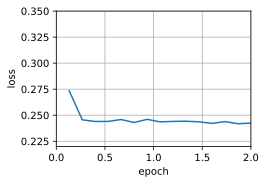

In [23]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adagrad, init_adagrad_states(feature_dim),
               {'lr': 0.1}, data_iter, feature_dim);

###**12.7.5. 简洁实现（Concise Implementation）**

loss: 0.242, 0.161 sec/epoch


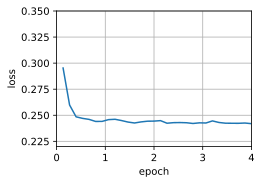

In [24]:
trainer = torch.optim.Adagrad
d2l.train_concise_ch11(trainer, {'lr': 0.1}, data_iter)

##**12.8. RMSProp算法（RMSProp）**

我们在AdaGrad算法中提到，因为调整学习率时分母上的变量 $\boldsymbol{s}_t$ 一直在累加按元素平方的小批量随机梯度，所以目标函数自变量**每个元素的学习率在迭代过程中一直在降低（或不变）**。因此，当学习率在迭代早期降得较快且当前解依然不佳时，AdaGrad算法在迭代后期由于学习率过小，可能较难找到一个有用的解。为了解决这一问题，RMSProp 算法对 AdaGrad 算法做了一点小小的修改。

###**12.8.1. 算法（The Algorithm）**

我们在动量法里介绍过指数加权移动平均。不同于 AdaGrad 算法里状态变量 $\boldsymbol{s}_t$ 是截至时间步 $t$ 所有小批量随机梯度 $\boldsymbol{g}_t$ 按元素平方和，RMSProp 算法将这些梯度按元素平方做指数加权移动平均。具体来说，给定超参数 $0 \leq \gamma < 1$，RMSProp 算法在时间步 $t>0$ 计算

$$\boldsymbol{s}_t \leftarrow \gamma \boldsymbol{s}_{t-1} + (1 - \gamma) \boldsymbol{g}_t \odot \boldsymbol{g}_t. $$

和 AdaGrad 算法一样，RMSProp 算法将目标函数自变量中每个元素的学习率通过按元素运算重新调整，然后更新自变量

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \frac{\eta}{\sqrt{\boldsymbol{s}_t + \epsilon}} \odot \boldsymbol{g}_t, $$

其中 $\eta$ 是学习率，$\epsilon$ 是为了维持数值稳定性而添加的常数，如$10^{-6}$。因为 RMSProp 算法的状态变量 $\boldsymbol{s}_t$ 是对平方项 $\boldsymbol{g}_t \odot \boldsymbol{g}_t$ 的指数加权移动平均，所以可以看作是最近 $1/(1-\gamma)$ 个时间步的小批量随机梯度平方项的加权平均。如此一来，自变量每个元素的学习率在迭代过程中就不再一直降低（或不变）。

**RMSProp 算法和 AdaGrad 算法的不同在于，RMSProp 算法使用了小批量随机梯度按元素平方的指数加权移动平均来调整学习率。**

###**12.8.2. 从零开始实现（Implementation from Scratch）**

照例，让我们先观察 RMSProp 算法对目标函数 $f(\boldsymbol{x})=0.1x_1^2+2x_2^2$ 中自变量的迭代轨迹。在之前使用的学习率为 0.4 的AdaGrad算法，自变量在迭代后期的移动幅度较小。但在同样的学习率下，RMSProp 算法可以更快逼近最优解。

epoch 20, x1: -0.010599, x2: 0.000000


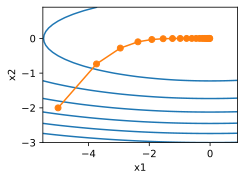

In [26]:
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.9
d2l.show_trace_2d(f_2d, d2l.train_2d(rmsprop_2d))

In [27]:
def init_rmsprop_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] = gamma * s + (1 - gamma) * torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

我们将初始学习率设为0.01，并将超参数$\gamma$设为0.9。此时，变量$\boldsymbol{s}_t$可看作是最近$1/(1-0.9) = 10$个时间步的平方项$\boldsymbol{g}_t \odot \boldsymbol{g}_t$的加权平均。

loss: 0.247, 0.223 sec/epoch


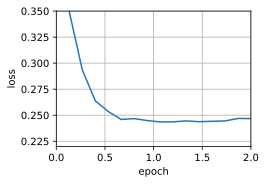

In [28]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(rmsprop, init_rmsprop_states(feature_dim),
               {'lr': 0.01, 'gamma': 0.9}, data_iter, feature_dim);

###**12.8.3. 简洁实现（Concise Implementation）**

loss: 0.243, 0.154 sec/epoch


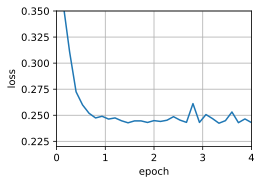

In [29]:
trainer = torch.optim.RMSprop
d2l.train_concise_ch11(trainer, {'lr': 0.01, 'alpha': 0.9},
                       data_iter)

## **12.9. AdaDelta算法（Adadelta）**

除了 RMSProp 算法以外，另一个常用优化算法 AdaDelta 算法也针对 AdaGrad 算法在迭代后期可能较难找到有用解的问题做了改进。有意思的是，**AdaDelta 算法没有学习率这一超参数**。

###**12.9.1. 算法（*The Algorithm*）**

AdaDelta 算法也像 RMSProp 算法一样，使用了小批量随机梯度 $\boldsymbol{g}_t$ 按元素平方的指数加权移动平均变量 $\boldsymbol{s}_t$。在时间步 0，它的所有元素被初始化为 0。给定超参数 $0 \leq \rho < 1$（对应 RMSProp 算法中的 $\beta$），在时间步 $t>0$，同 RMSProp 算法一样计算

$$\boldsymbol{s}_t \leftarrow \rho \boldsymbol{s}_{t-1} + (1 - \rho) \boldsymbol{g}_t \odot \boldsymbol{g}_t. $$

与 RMSProp 算法不同的是，AdaDelta 算法还维护一个额外的状态变量 $\Delta\boldsymbol{x}_t$，其元素同样在时间步 0 时被初始化为 0。我们使用 $\Delta\boldsymbol{x}_{t-1}$ 来计算自变量的变化量：

$$ \boldsymbol{g}_t' \leftarrow \sqrt{\frac{\Delta\boldsymbol{x}_{t-1} + \epsilon}{\boldsymbol{s}_t + \epsilon}}   \odot \boldsymbol{g}_t, $$

其中 $\epsilon$ 是为了维持数值稳定性而添加的常数，如 $10^{-5}$。接着更新自变量：

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{g}'_t. $$

最后，我们使用 $\Delta\boldsymbol{x}_t$ 来记录自变量变化量 $\boldsymbol{g}'_t$ 按元素平方的指数加权移动平均：

$$\Delta\boldsymbol{x}_t \leftarrow \rho \Delta\boldsymbol{x}_{t-1} + (1 - \rho) \boldsymbol{g}'_t \odot \boldsymbol{g}'_t. $$

可以看到，如不考虑 $\epsilon$ 的影响，**AdaDelta 算法跟 RMSProp 算法的不同之处在于使用 $\sqrt{\Delta\boldsymbol{x}_{t-1}}$ 来替代学习率$\eta$**。

###**12.9.2. 实现（*Implementation*）**

In [30]:
%matplotlib inline
import torch
from d2l import torch as d2l


def init_adadelta_states(feature_dim):
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    delta_w, delta_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        with torch.no_grad():
            # In-place updates via [:]
            s[:] = rho * s + (1 - rho) * torch.square(p.grad)
            g = (torch.sqrt(delta + eps) / torch.sqrt(s + eps)) * p.grad
            p[:] -= g
            delta[:] = rho * delta + (1 - rho) * g * g
        p.grad.data.zero_()

Choosing $\rho = 0.9$ amounts to a half-life time of 10 for each parameter update. This tends to work quite well. We get the following behavior.

loss: 0.243, 0.207 sec/epoch


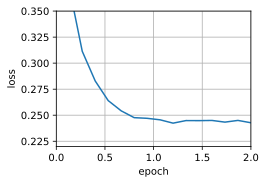

In [31]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adadelta, init_adadelta_states(feature_dim),
               {'rho': 0.9}, data_iter, feature_dim);

为了简洁实现，我们只需使用高级API中的Adadelta算法。

loss: 0.243, 0.173 sec/epoch


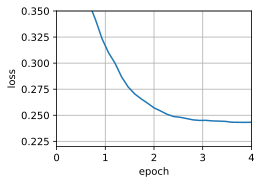

In [32]:
trainer = torch.optim.Adadelta
d2l.train_concise_ch11(trainer, {'rho': 0.9}, data_iter)

##**12.10. Adam算法（Adam）**

Adam 算法在 RMSProp 算法基础上对小批量随机梯度也做了指数加权移动平均。所以 Adam 算法可以看做是 RMSProp 算法与动量法的结合。

###**12.10.1. 算法（*The Algorithm*）**

Adam 算法使用了动量变量 $\boldsymbol{v}_t$ 和 RMSProp 算法中小批量随机梯度按元素平方的指数加权移动平均变量 $\boldsymbol{s}_t$，并在时间步 0 将它们中每个元素初始化为 0。给定超参数 $0 \leq \beta_1 < 1$（算法作者建议设为 0.9），时间步 $t$ 的动量变量 $\boldsymbol{v}_t$ 即小批量随机梯度 $\boldsymbol{g}_t$ 的指数加权移动平均：

$$\boldsymbol{v}_t \leftarrow \beta_1 \boldsymbol{v}_{t-1} + (1 - \beta_1) \boldsymbol{g}_t. $$

和 RMSProp 算法中一样，给定超参数 $0 \leq \beta_2 < 1$（算法作者建议设为0.999），
将小批量随机梯度按元素平方后的项 $\boldsymbol{g}_t \odot \boldsymbol{g}_t$ 做指数加权移动平均得到 $\boldsymbol{s}_t$：

$$\boldsymbol{s}_t \leftarrow \beta_2 \boldsymbol{s}_{t-1} + (1 - \beta_2) \boldsymbol{g}_t \odot \boldsymbol{g}_t. $$

由于我们将 $\boldsymbol{v}_0$ 和 $\boldsymbol{s}_0$ 中的元素都初始化为 0，
在时间步 $t$ 我们得到 $\boldsymbol{v}_t =  (1-\beta_1) \sum_{i=1}^t \beta_1^{t-i} \boldsymbol{g}_i$。将过去各时间步小批量随机梯度的权值相加，得到 $(1-\beta_1) \sum_{i=1}^t \beta_1^{t-i} = 1 - \beta_1^t$。需要注意的是，当 $t$ 较小时，过去各时间步小批量随机梯度权值之和会较小。例如，当 $\beta_1 = 0.9$ 时，$\boldsymbol{v}_1 = 0.1\boldsymbol{g}_1$。为了消除这样的影响，对于任意时间步 $t$，我们可以将 $\boldsymbol{v}_t$ 再除以 $1 - \beta_1^t$，从而使过去各时间步小批量随机梯度权值之和为1。这也叫作偏差修正。在 Adam 算法中，我们对变量 $\boldsymbol{v}_t$和$\boldsymbol{s}_t$ 均作偏差修正：

$$\hat{\boldsymbol{v}}_t \leftarrow \frac{\boldsymbol{v}_t}{1 - \beta_1^t}, $$

$$\hat{\boldsymbol{s}}_t \leftarrow \frac{\boldsymbol{s}_t}{1 - \beta_2^t}. $$


接下来，Adam 算法使用以上偏差修正后的变量 $\hat{\boldsymbol{v}}_t$ 和 $\hat{\boldsymbol{s}}_t$，将模型参数中每个元素的学习率通过按元素运算重新调整：

$$\boldsymbol{g}_t' \leftarrow \frac{\eta \hat{\boldsymbol{v}}_t}{\sqrt{\hat{\boldsymbol{s}}_t} + \epsilon},$$

其中 $\eta$ 是学习率，$\epsilon$ 是为了维持数值稳定性而添加的常数，如 $10^{-8}$。和 AdaGrad 算法、RMSProp 算法以及 AdaDelta 算法一样，目标函数自变量中每个元素都分别拥有自己的学习率。最后，使用 $\boldsymbol{g}_t'$ 迭代自变量：

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{g}_t'. $$

###**12.10.2. 实现（*Implementation*）**

In [33]:
%matplotlib inline
import torch
from d2l import torch as d2l


def init_adam_states(feature_dim):
    v_w, v_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

使用学习率为0.01的Adam算法来训练模型。

loss: 0.243, 0.219 sec/epoch


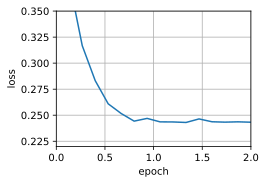

In [34]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adam, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);

此外，我们可以用深度学习框架自带算法应用Adam算法，这里我们只需要传递配置参数。

loss: 0.243, 0.161 sec/epoch


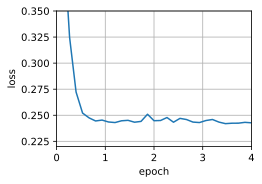

In [35]:
trainer = torch.optim.Adam
d2l.train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

In [36]:
%%shell
jupyter nbconvert --to html 12_D2L_Optimization_Algorithms.ipynb

[NbConvertApp] Converting notebook 12_D2L_Optimization_Algorithms.ipynb to html
[NbConvertApp] Writing 1371594 bytes to 12_D2L_Optimization_Algorithms.html
